Initial notebook for exploratory data analysis and modeling of the 2019 [Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2019/overview). Sorry it's messy, there's a lot of exploration going on. 

Author: Mike Lo  
Date modified: 10/30/2019


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import reduce
from pandas.io.json import json_normalize #package for flattening json in pandas df

# from plotly import tools, subplots
# import plotly.offline as py
# py.init_notebook_mode(connected = True)
# import plotly.graph_objs as go
# import plotly.express as px
# pd.set_option('max_columns', 1000)
# from bokeh.models import Panel, Tabs
# from bokeh.io import output_notebook, show
# from bokeh.plotting import figure
# import lightgbm as lgb
# import plotly.figure_factory as ff
# import gc
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

input_dir = '../data/'
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/sample_submission.csv
../data/specs.csv
../data/test.csv
../data/train.csv
../data/train_labels.csv


# Information on the dataset

## Overview
In this dataset, you are provided with game analytics for the PBS KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.

The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt). Each application install is represented by an `installation_id`. This will typically correspond to one child, but you should expect noise from issues such as shared devices. In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many `installation_ids` which never took assessments, whereas every `installation_id` in the test set made an attempt on at least one assessment.

## Datasets
__train.csv & test.csv__

These are the main data files which contain the gameplay events.  
`event_id` - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.  
`game_session` - Randomly generated unique identifier grouping events within a single game or video play session.  
`timestamp` - Client-generated datetime  
`event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.  
`installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.  
`event_count` - Incremental counter of events within a game session (offset at 1). _Extracted from event_data_.  
`event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. _Extracted from event_data_.  
`game_time` - Time in milliseconds since the start of the game session. _Extracted from event_data_.  
`title` - Title of the game or video.  
`type` - Media type of the game or video. Possible values are: __Game__, __Assessment__, __Activity__, __Clip__.  
`world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: __NONE__ (at the app's start screen), __TREETOPCITY__ (Length/Height), __MAGMAPEAK__ (Capacity/Displacement), __CRYSTALCAVES__ (Weight).  

__specs.csv__

This file gives the specification of the various event types.  
`event_id` - Global unique identifier for the event type. Joins to event_id column in events table.  
`info` - Description of the event.  
`args` - JSON formatted string of event arguments. Each argument contains:  
`name` - Argument name.  
`type` - Type of the argument (string, int, number, object, array).  
`info` - Description of the argument.  

__train_labels.csv__

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):  
3) the assessment was solved on the first attempt  
2) the assessment was solved on the second attempt  
1) the assessment was solved after 3 or more attempts  
0) the assessment was never solved  

This is a classification problem (matching data from each `installation_id` to outcome).

## The goal
For each `installation_id` represented in the test set, you must predict the `accuracy_group` of the __LAST__ assessment for that `installation_id`.

Load and get an overall sense of the data.

In [2]:
%time df = pd.read_csv(input_dir + 'train.csv') # takes a while to load 
print('Unique # of event types (event_ids): {}'.format(df['event_id'].unique().size))
print('Unique # of event classes (event_codes): {}'.format(df['event_code'].unique().size))
print('Unique # of activity types (type): {}'.format(df['type'].unique().size))
print('Unique # of titles (title): {}'.format(df['title'].unique().size))
print('Unique # of worlds (world): {}'.format(df['world'].unique().size))

CPU times: user 51.8 s, sys: 4.53 s, total: 56.3 s
Wall time: 1min 44s
Unique # of event types (event_ids): 384
Unique # of event classes (event_codes): 42
Unique # of activity types (type): 4
Unique # of titles (title): 44
Unique # of worlds (world): 4


In [40]:
df1 = df.sample(10000, random_state=123)
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1['hour_of_day'] = df1['timestamp'].dt.hour
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 5636270 to 7252641
Data columns (total 12 columns):
event_id           10000 non-null object
game_session       10000 non-null object
timestamp          10000 non-null datetime64[ns, UTC]
event_data         10000 non-null object
installation_id    10000 non-null object
event_count        10000 non-null int64
event_code         10000 non-null int64
game_time          10000 non-null int64
title              10000 non-null object
type               10000 non-null object
world              10000 non-null object
hour_of_day        10000 non-null int64
dtypes: datetime64[ns, UTC](1), int64(4), object(7)
memory usage: 1015.6+ KB


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,hour_of_day
5636270,a0faea5d,05df65df7c0b242d,2019-10-12 14:51:50.069000+00:00,"{""coordinates"":{""x"":442,""y"":455,""stage_width"":...",7cea4e3e,53,4070,127000,Bubble Bath,Game,MAGMAPEAK,14
4693790,1325467d,b761f354302597b9,2019-08-16 05:43:38.201000+00:00,"{""coordinates"":{""x"":846,""y"":198,""stage_width"":...",69070a06,166,4070,128163,Sandcastle Builder (Activity),Activity,MAGMAPEAK,5
9401646,499edb7c,b4c71262292cb86b,2019-08-01 00:34:46.224000+00:00,"{""side"":""right"",""layout"":{""left"":{""chickens"":0...",d25338cb,10,4020,12469,Chicken Balancer (Activity),Activity,CRYSTALCAVES,0
7828316,c1cac9a2,3fb455470932241c,2019-07-26 20:38:01.637000+00:00,"{""movie_id"":""scrubadub_outro"",""duration"":13900...",af6786f7,234,2081,227437,Scrub-A-Dub,Game,MAGMAPEAK,20
100871,71fe8f75,01ad4b9194ada027,2019-09-09 20:32:04.828000+00:00,"{""description"":""Two!"",""identifier"":""sid_2"",""me...",0235fe9a,147,3110,63594,Bug Measurer (Activity),Activity,TREETOPCITY,20


# EDA 


## Check training data
Start by checking the properties of different features.

Check the different types of games or activities that are played

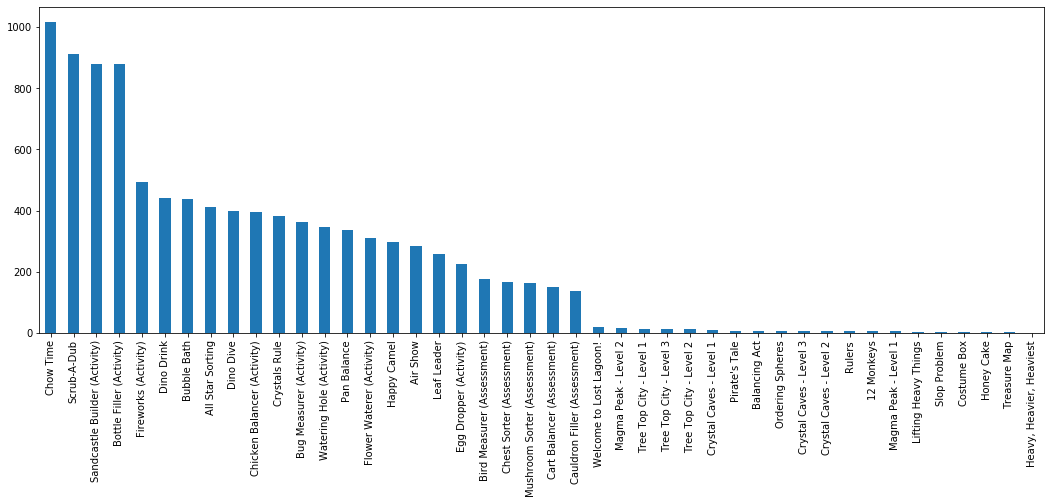

In [41]:
_, ax = plt.subplots(figsize=(18,6))
df1['title'].value_counts().plot.bar();

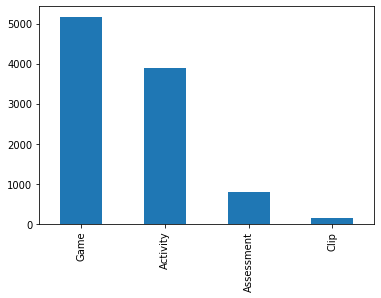

In [42]:
# distribution of activity
df1['type'].value_counts().plot.bar();

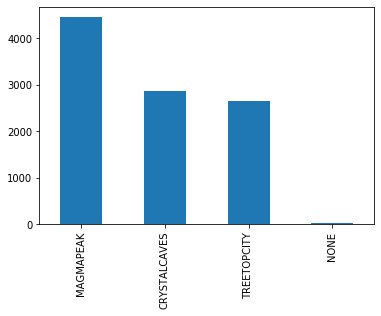

In [43]:
# distribution of worlds
df1['world'].value_counts().plot.bar();

mean game time: 3.57 minutes
median game time: 1.28 minutes


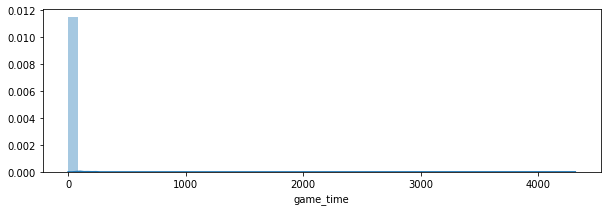

In [44]:
# time played
print('mean game time: {0:.2f} minutes'.format(df1[df1['game_time'] > 0]['game_time'].mean()/1e3/60))
print('median game time: {0:.2f} minutes'.format(df1[df1['game_time'] > 0]['game_time'].median()/1e3/60))
_, ax = plt.subplots(figsize=(10,3))
sns.distplot(df1[df1['game_time'] > 10]['game_time']/1e3/60);

In [45]:
# Time range of data
[min(df1['timestamp']), max(df1['timestamp'])]

[Timestamp('2019-07-23 17:07:51.819000+0000', tz='UTC'),
 Timestamp('2019-10-14 21:43:59.651000+0000', tz='UTC')]

In [46]:
# check what event_data contains
df1.iloc[1]

event_id                                                    1325467d
game_session                                        b761f354302597b9
timestamp                           2019-08-16 05:43:38.201000+00:00
event_data         {"coordinates":{"x":846,"y":198,"stage_width":...
installation_id                                             69070a06
event_count                                                      166
event_code                                                      4070
game_time                                                     128163
title                                  Sandcastle Builder (Activity)
type                                                        Activity
world                                                      MAGMAPEAK
hour_of_day                                                        5
Name: 4693790, dtype: object

In [47]:
df1[df1['type'] == 'Activity'].iloc[1]['event_data']


'{"side":"right","layout":{"left":{"chickens":0,"pig":false},"right":{"chickens":2,"pig":false}},"coordinates":{"x":741,"y":536,"stage_width":1015,"stage_height":762},"duration":2183,"source":"resources","event_count":10,"game_time":12469,"event_code":4020}'

In [48]:
df1[df1['type'] == 'Clip'].iloc[1]['event_data']

'{"event_code": 2000, "event_count": 1}'

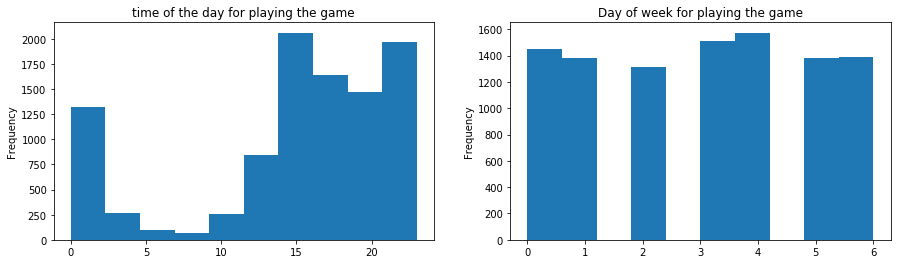

In [49]:
_, ax = plt.subplots(1, 2, figsize=(15,4))
df1['timestamp'].dt.hour.plot.hist(ax=ax[0]);
ax[0].set_title('time of the day for playing the game')
df1['timestamp'].dt.dayofweek.plot.hist(ax=ax[1])
ax[1].set_title('Day of week for playing the game');

## Check the labels

In [50]:
labels = pd.read_csv(input_dir + 'train_labels.csv')
labels.tail()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0
17689,dadd1a4d8ac68ab0,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1


In [51]:
labels.info()
# 17690 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [52]:
print('Shape: {}'.format(labels.shape))
print('Number of unique devices (installation_id): {}'.format(labels['installation_id'].unique().size))

Shape: (17690, 7)
Number of unique devices (installation_id): 3614


There are 17,690 unique game sessions, played on 3,614 unique devices. Each unique `game_session` ID in labels is linked to the training data. We should group training data by `game_session` and process the data that way.

## Explore information in `event_data`
Check the differences in content of the feature

In [53]:
# expands json into individual columns
import json
%time df_j = df1['event_data'].apply(json.loads).apply(pd.Series) # 12 min?!
# dft.head()
df_j.shape
df_j.tail()

CPU times: user 4.62 s, sys: 42 ms, total: 4.66 s
Wall time: 4.66 s


,coordinates,round,event_count,game_time,event_code,side,layout,duration,source,movie_id,...,max_position,end_position,starting_weights,stumps,buglength,round_prompt,containers,dwell_time,stage_number,molds
6708315,NaN,1.0,16.0,23820.0,3020.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9968483,"{'x': 528, 'y': 168, 'stage_width': 1014, 'sta...",1.0,46.0,101701.0,4235.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5246155,NaN,NaN,45.0,58671.0,3010.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6419523,NaN,20.0,159.0,172441.0,3110.0,NaN,NaN,3536.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7252641,NaN,4.0,54.0,55249.0,3021.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


coordinates    0.5073
round          0.6049
event_count    1.0000
game_time      0.9853
event_code     1.0000
dtype: float64

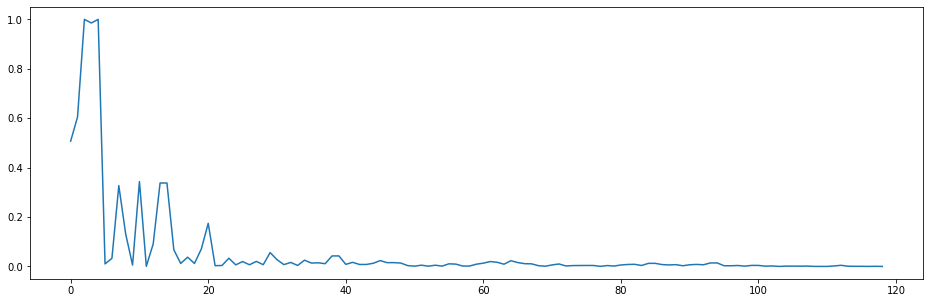

In [54]:
# see which event_data is useful or has least na
not_na = df_j.notna().sum(axis=0)/df_j.shape[0]
_, ax = plt.subplots(figsize = (16,5))
sns.lineplot(x=np.arange(df_j.shape[1]), y=not_na);
not_na[not_na > 0.4]

As you can see from above, most information in `event_data` is missing. `round` may be useful. `event_count` and `event_code` are already part of the dataframe.

## Check specs.csv
Specs maps to `event_id`.

In [55]:
dfspecs = pd.read_csv(input_dir + 'specs.csv')
dfspecs.head()
dfspecs.iloc[100, 1]

'This event occurs when the player clicks on something that isn’t covered elsewhere. It can be useful in determining if there are attractive distractions (things the player think should do something, but don’t) in the game, or diagnosing players who are having mechanical difficulties (near misses).'

## Explanation of the features

* Note that training labels only contain __Assessment__ type data. Other types (__Game__, __Activity__, __Clip__) are not available. How can we use data from other types for prediction? 
* Not all user with `installation_id` did assessment when they played. __How to use those data without labels?__
* `installation_id` is assigned to each device that downloaded the game. Each ID (i.e. device) can have multiple `game_session` rows (although the session ID is unique), played by the same or a different person.
* Within each session (of the game `title`, which can be activities, assessment, video clips, or games), each action taken by the agent is labeled with a fully unique `event_id`. 
* `event_code` classifies the event taken. It's unique within each game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. 
* All actions are enumerated by `event_count` that ranges from 1 on up. `game_time` measures the amount of time since start of `game_session`.
* Each `type` contains the media type can be further broken down into different categories.
* Each `event_data` contains many different keys-value pairs that don't seem to correlate with the `type`. 

## Some initial ideas for how to go on

* time series analysis on the `event_count` and `game_time`
* further extract useful info from `event_data` (e.g. descriptions, coordinates, etc)
* correlation analysis between outcome and `type`, `world`, `title`, and `event_code` 
* max `event_count` could be a potential feature -- fewer number of tries before completion could be an indicator of good education material 

# Data preparation
Do feature selection, normalization, feature engineering, and impute missing values.

In [56]:
# test
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1['hour_of_day'] = df1['timestamp'].dt.hour
df1.head()

# factorize game titles (i.e. encode them into integers)
df1['title_n'], uniques = df1['title'].factorize()
mapping_title = dict(zip(df1['title_n'], uniques.take(df1['title_n'])))
# factorize game world
df1['world_n'], uniques = df1['world'].factorize()
mapping_world = dict(zip(df1['world_n'], uniques.take(df1['world_n'])))
# factorize activity type
df1['type_n'], uniques = df1['type'].factorize()
mapping_type = dict(zip(df1['type_n'], uniques.take(df1['type_n'])))
# factorize event codes
df1['code_n'], uniques = df1['event_code'].factorize()
mapping_type = dict(zip(df1['code_n'], uniques.take(df1['code_n'])))
# hour of day when game is played
df1['hour_of_day'] = df1['timestamp'].dt.hour

print(mapping_world)
print(mapping_title)
print(mapping_type)

df1.head()

{0: 'MAGMAPEAK', 1: 'CRYSTALCAVES', 2: 'TREETOPCITY', 3: 'NONE'}
{0: 'Bubble Bath', 1: 'Sandcastle Builder (Activity)', 2: 'Chicken Balancer (Activity)', 3: 'Scrub-A-Dub', 4: 'Bug Measurer (Activity)', 5: 'Chow Time', 6: 'Crystals Rule', 7: 'Bottle Filler (Activity)', 8: 'Bird Measurer (Assessment)', 9: 'Egg Dropper (Activity)', 10: 'Air Show', 11: 'Dino Dive', 12: 'All Star Sorting', 13: 'Leaf Leader', 14: 'Pan Balance', 15: 'Fireworks (Activity)', 16: 'Dino Drink', 17: 'Flower Waterer (Activity)', 18: 'Chest Sorter (Assessment)', 19: 'Watering Hole (Activity)', 20: 'Happy Camel', 21: 'Mushroom Sorter (Assessment)', 22: 'Heavy, Heavier, Heaviest', 23: 'Cart Balancer (Assessment)', 24: 'Magma Peak - Level 2', 25: 'Welcome to Lost Lagoon!', 26: 'Treasure Map', 27: 'Cauldron Filler (Assessment)', 28: 'Crystal Caves - Level 1', 29: 'Crystal Caves - Level 3', 30: 'Tree Top City - Level 1', 31: 'Rulers', 32: 'Tree Top City - Level 2', 33: '12 Monkeys', 34: 'Lifting Heavy Things', 35: 'Costu

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,hour_of_day,title_n,world_n,type_n,code_n
5636270,a0faea5d,05df65df7c0b242d,2019-10-12 14:51:50.069000+00:00,"{""coordinates"":{""x"":442,""y"":455,""stage_width"":...",7cea4e3e,53,4070,127000,Bubble Bath,Game,MAGMAPEAK,14,0,0,0,0
4693790,1325467d,b761f354302597b9,2019-08-16 05:43:38.201000+00:00,"{""coordinates"":{""x"":846,""y"":198,""stage_width"":...",69070a06,166,4070,128163,Sandcastle Builder (Activity),Activity,MAGMAPEAK,5,1,0,1,0
9401646,499edb7c,b4c71262292cb86b,2019-08-01 00:34:46.224000+00:00,"{""side"":""right"",""layout"":{""left"":{""chickens"":0...",d25338cb,10,4020,12469,Chicken Balancer (Activity),Activity,CRYSTALCAVES,0,2,1,1,1
7828316,c1cac9a2,3fb455470932241c,2019-07-26 20:38:01.637000+00:00,"{""movie_id"":""scrubadub_outro"",""duration"":13900...",af6786f7,234,2081,227437,Scrub-A-Dub,Game,MAGMAPEAK,20,3,0,0,2
100871,71fe8f75,01ad4b9194ada027,2019-09-09 20:32:04.828000+00:00,"{""description"":""Two!"",""identifier"":""sid_2"",""me...",0235fe9a,147,3110,63594,Bug Measurer (Activity),Activity,TREETOPCITY,20,4,2,1,3


In [57]:
# test
# let's carefully study the game with the most number of events
sesh_longest = df[df['event_count'] == df['event_count'].max()]['game_session'].tolist()[0]
df2 = df[df['game_session'] == sesh_longest]
print('Number of events: {}'.format(df2.size))
print('Number of unique events: {}'.format(df2['event_id'].unique().size))
df2.head()

Number of events: 37048
Number of unique events: 9


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
4989649,9b01374f,6e6e697f2e593de1,2019-09-13T19:18:01.221Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",6f858013,1,2000,0,Flower Waterer (Activity),Activity,TREETOPCITY
4989650,56cd3b43,6e6e697f2e593de1,2019-09-13T19:18:01.609Z,"{""description"":""Welcome to the garden! Which c...",6f858013,2,3010,371,Flower Waterer (Activity),Activity,TREETOPCITY
4989651,a44b10dc,6e6e697f2e593de1,2019-09-13T19:18:02.006Z,"{""coordinates"":{""x"":397,""y"":647,""stage_width"":...",6f858013,3,4070,909,Flower Waterer (Activity),Activity,TREETOPCITY
4989652,bbfe0445,6e6e697f2e593de1,2019-09-13T19:18:08.342Z,"{""description"":""Welcome to the garden! Which c...",6f858013,4,3110,7355,Flower Waterer (Activity),Activity,TREETOPCITY
4989653,5d042115,6e6e697f2e593de1,2019-09-13T19:18:11.611Z,"{""flowers"":[0,0,0,0,0],""flower"":0,""coordinates...",6f858013,5,4030,10590,Flower Waterer (Activity),Activity,TREETOPCITY


In [58]:
# tests
df3 = labels.copy()
max_event_counts = df1.groupby('game_session')[['event_count']].max().reset_index()
max_event_counts.rename(columns = {'event_count':'max_event_counts'}, inplace=True)
df4 = df3.merge(right=max_event_counts, on='game_session', how='inner')
df4.head()
# max_event_counts.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,max_event_counts
0,dd06aeacbb593d36,00e536bf,Chest Sorter (Assessment),1,0,1.0,3,5
1,3cb1a0a7c6e5c4cb,00fc65b6,Cart Balancer (Assessment),1,0,1.0,3,14
2,93b8e335aad20961,01f71702,Cauldron Filler (Assessment),1,1,0.5,2,36
3,aa2a5310a5c10bc4,027b3c4c,Chest Sorter (Assessment),1,0,1.0,3,13
4,1593e825018cafe7,02b1fab4,Mushroom Sorter (Assessment),1,0,1.0,3,30


In [59]:
# test
df1['hour_of_day'] = df1['timestamp'].dt.hour
mean_event_time = df1.groupby('game_session')[['hour_of_day']].mean().reset_index()
mean_event_time.rename(columns = {'game_time':'mean_event_time'}, inplace=True)
# df4 = df3.merge(right=mean_game_time, on='game_session', how='inner')
df1.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,hour_of_day,title_n,world_n,type_n,code_n
5636270,a0faea5d,05df65df7c0b242d,2019-10-12 14:51:50.069000+00:00,"{""coordinates"":{""x"":442,""y"":455,""stage_width"":...",7cea4e3e,53,4070,127000,Bubble Bath,Game,MAGMAPEAK,14,0,0,0,0
4693790,1325467d,b761f354302597b9,2019-08-16 05:43:38.201000+00:00,"{""coordinates"":{""x"":846,""y"":198,""stage_width"":...",69070a06,166,4070,128163,Sandcastle Builder (Activity),Activity,MAGMAPEAK,5,1,0,1,0
9401646,499edb7c,b4c71262292cb86b,2019-08-01 00:34:46.224000+00:00,"{""side"":""right"",""layout"":{""left"":{""chickens"":0...",d25338cb,10,4020,12469,Chicken Balancer (Activity),Activity,CRYSTALCAVES,0,2,1,1,1
7828316,c1cac9a2,3fb455470932241c,2019-07-26 20:38:01.637000+00:00,"{""movie_id"":""scrubadub_outro"",""duration"":13900...",af6786f7,234,2081,227437,Scrub-A-Dub,Game,MAGMAPEAK,20,3,0,0,2
100871,71fe8f75,01ad4b9194ada027,2019-09-09 20:32:04.828000+00:00,"{""description"":""Two!"",""identifier"":""sid_2"",""me...",0235fe9a,147,3110,63594,Bug Measurer (Activity),Activity,TREETOPCITY,20,4,2,1,3


In [60]:
# test
df1[df1['game_session'] == df1['game_session'].iloc[1]]
df4.merge(right=df1[['game_session', 'title_n']], on='game_session', how='inner')

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,max_event_counts,title_n
0,dd06aeacbb593d36,00e536bf,Chest Sorter (Assessment),1,0,1.0,3,5,18
1,3cb1a0a7c6e5c4cb,00fc65b6,Cart Balancer (Assessment),1,0,1.0,3,14,23
2,93b8e335aad20961,01f71702,Cauldron Filler (Assessment),1,1,0.5,2,36,27
3,aa2a5310a5c10bc4,027b3c4c,Chest Sorter (Assessment),1,0,1.0,3,13,18
4,1593e825018cafe7,02b1fab4,Mushroom Sorter (Assessment),1,0,1.0,3,30,21
...,...,...,...,...,...,...,...,...,...
735,47eacb3dfc60a941,fe5f0699,Mushroom Sorter (Assessment),1,0,1.0,3,18,21
736,4d757a1004d84860,fe73bf4b,Mushroom Sorter (Assessment),1,0,1.0,3,33,21
737,25d314ceadaed06d,ff107709,Cauldron Filler (Assessment),1,1,0.5,2,9,27
738,c19e33a37f4750ba,ff9305d7,Chest Sorter (Assessment),0,3,0.0,0,79,18


In [61]:
# test
# create one hot encoding of event_code
df_code = df1.groupby(['game_session', 'event_code']).size().to_frame(name='counts').reset_index()
df_code = df_code.pivot(index='game_session', columns='event_code', values='counts')
df_code[df_code.isna()] = 0
df_code.reset_index(inplace=True)
df_code.iloc[:, 1:] = df_code.iloc[:, 1:].astype(int)

# df_code.columns = df_code.columns.get_level_values(0)
df_code.iloc[100:200, :]

event_code,game_session,2000,2010,2020,2025,2030,2035,2040,2050,2060,...,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010
100,02805e743d8794bc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0284120b9ce2df60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0295638e917a48ab,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,02a70e257ed0d594,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,02a83467daf42add,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,05df26747546e2c5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,05df65df7c0b242d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,05e1eb15077d44d1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,05ed1cb53ca2e126,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
def prepare_input(df, train=True):
    '''function to generate training data from raw dataframe (df)'''
    if train: 
        cdf = labels.copy()
    elif not train:
        cdf = df[['game_session']].copy()
    
    # map world, type and title to labels
    map_world = dict(zip(df['game_session'].tolist(), df['world'].tolist()))
    map_type = dict(zip(df['game_session'].tolist(), df['type'].tolist()))
    map_title = dict(zip(df['game_session'].tolist(), df['title'].tolist()))    
    cdf['world'] = cdf['game_session'].map(map_world)
    cdf['type'] = cdf['game_session'].map(map_type)
#     cdf['title'] = cdf['game_session'].map(map_title)
    
    # create normalized count of event_code per code
#     max_event_code = df.groupby(['game_session', 'event_code']).size().sort_values().max(level=0).to_frame(name='event_code_mode')
#     cdf = cdf.merge(right=code_mode_event, on='game_session', how='inner')    
    
    # create max_event_count
    max_event_counts = df.groupby('game_session')[['event_count']].max().reset_index()
    max_event_counts.rename(columns = {'event_count':'max_event_counts'}, inplace=True)
    
    # create hour_of_day of game play
    hour_of_day = df.groupby('game_session')[['hour_of_day']].mean().reset_index()
    hour_of_day.rename(columns = {'game_time':'hour_of_day'}, inplace=True)
    
    # add mean_game_time
#     mean_event_time = df.groupby('game_session')[['game_time']].mean().reset_index()
#     mean_event_time.rename(columns = {'game_time':'mean_event_time'}, inplace=True)
#     cdf.merge(right=mean_game_time, on='game_session', how='inner')

    # 
    
    # pivot and create one hot encoding for event_code
    event_codes = df.groupby(['game_session', 'event_code']).size().to_frame(name='counts').reset_index()
    event_codes = event_codes.pivot(index='game_session', columns='event_code', values='counts')
    event_codes[event_codes.isna()] = 0
    event_codes.reset_index(inplace=True)
    event_codes.iloc[:, 1:] = event_codes.iloc[:, 1:].astype(int)
    
    # get all game titles

    # merge dfs
    dfs = [cdf, max_event_counts, hour_of_day, event_codes]
    cdf = reduce(lambda left, right: pd.merge(left, right, on='game_session', how='inner'), dfs)
    
    # one hot encode
    cdf = pd.get_dummies(cdf, columns=['world', 'type'])
    return cdf

In [63]:
cdf = prepare_input(df1)
cdf = cdf[['accuracy_group'] + [c for c in cdf if c not in ['accuracy_group']]]
cdf.head()

,accuracy_group,game_session,installation_id,title,num_correct,num_incorrect,accuracy,max_event_counts,hour_of_day,2000,...,4110,4220,4230,4235,5000,5010,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY,type_Assessment
0,3,dd06aeacbb593d36,00e536bf,Chest Sorter (Assessment),1,0,1.0,5,21.0,0,...,0,0,0,0,0,0,1,0,0,1
1,3,3cb1a0a7c6e5c4cb,00fc65b6,Cart Balancer (Assessment),1,0,1.0,14,13.0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,93b8e335aad20961,01f71702,Cauldron Filler (Assessment),1,1,0.5,36,13.0,0,...,0,0,0,0,0,0,0,1,0,1
3,3,aa2a5310a5c10bc4,027b3c4c,Chest Sorter (Assessment),1,0,1.0,13,16.0,0,...,0,0,0,0,0,0,1,0,0,1
4,3,1593e825018cafe7,02b1fab4,Mushroom Sorter (Assessment),1,0,1.0,30,16.0,0,...,0,0,0,0,0,0,0,0,1,1


normalization?

correlation analysis?

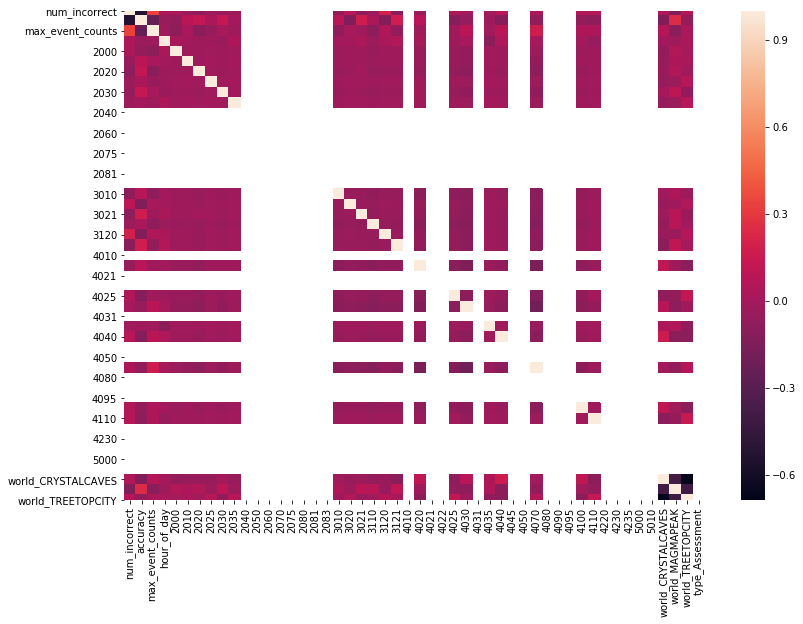

In [64]:
# correlation matrix
_, ax = plt.subplots(figsize=(13,9))
corr = cdf.iloc[:, 5:].corr()
sns.heatmap(corr);

# Modeling
Set up a basic skeleton for modeling.

In [65]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [66]:
X = cdf.iloc[:, 7:]
y = cdf.iloc[:, 0]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [68]:
xg_reg = xgb.XGBClassifier(objective='reg:linear', 
                          colsample_bytree=0.3,
                          learning_rate=0.1,
                          max_depth=5,
                          alpha=10, 
                          n_estimators=10)

xg_reg.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [69]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print('RMSE: {}'.format(rmse))

RMSE: 1.575600673558336


# Evaluation

In [70]:
# define quadratic_weighted_kappa for evaluation
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [71]:
kappa = quadratic_weighted_kappa(preds, y_test)
kappa

0.296776517197911

# Predict unknown data

In [72]:
%time test = pd.read_csv(input_dir + '/test.csv')

CPU times: user 4.69 s, sys: 224 ms, total: 4.92 s
Wall time: 4.92 s


In [73]:
df_test = test.copy()
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test['hour_of_day'] = df_test['timestamp'].dt.hour
df_test = prepare_input(df_test, train=False)
df_test.drop(columns=['game_session', 'world_NONE', 'type_Activity', 'type_Clip', 'type_Game'], inplace=True)

In [99]:
# df[df['installation_id'] == df['installation_id'].iloc[0]]
df[df['installation_id'] == df['installation_id'].iloc[100]]['title'].unique()

array(['Welcome to Lost Lagoon!', 'Magma Peak - Level 1',
       'Sandcastle Builder (Activity)', 'Scrub-A-Dub',
       'Magma Peak - Level 2', 'Dino Drink', 'Tree Top City - Level 1',
       'Ordering Spheres'], dtype=object)

In [94]:
print(test.shape)
# df_test['instal']
# test[(test['installation_id'] == '00abaee7') & (test['event_id'] == '832735e1')].tail(30)#['title']#.unique()
# test[test['installation_id'] == '00abaee7'].tail(40)#['title']#.unique()
test[test['installation_id'] == '00abaee7']['title'].unique()

(1156414, 11)


array(['Welcome to Lost Lagoon!', 'Magma Peak - Level 1',
       'Magma Peak - Level 2', 'Crystal Caves - Level 1', 'Chow Time',
       'Balancing Act', 'Crystal Caves - Level 2',
       'Tree Top City - Level 1', 'All Star Sorting', 'Costume Box',
       'Fireworks (Activity)', '12 Monkeys', 'Lifting Heavy Things',
       'Cart Balancer (Assessment)', 'Crystal Caves - Level 3',
       'Egg Dropper (Activity)', 'Bug Measurer (Activity)',
       'Sandcastle Builder (Activity)', 'Dino Dive',
       'Cauldron Filler (Assessment)'], dtype=object)

In [75]:
# make predictions
test_preds = xg_reg.predict(df_test)

In [76]:
# prepare predictions for submission
# sample = pd.read_csv(input_dir + 'sample_submission.csv')
# sample
results = pd.DataFrame({'installation_id':test['installation_id'], 'accuracy_group':test_preds})
results.head()

,installation_id,accuracy_group
0,00abaee7,3
1,00abaee7,3
2,00abaee7,3
3,00abaee7,0
4,00abaee7,1


In [77]:
# submit results
# results.to_csv('submission.csv', index=False)